In [79]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gluonts.model.deepar import DeepAREstimator
from gluonts.model.forecast import SampleForecast
from gluonts.trainer import Trainer
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import Evaluator


from gluonts.evaluation.backtest import make_evaluation_predictions

In [2]:
static_cats = 2
dynamic_cats = 2
static_reals = 3
dynamic_reals = 4

base_shift = 7

freq = "D"


def get_period_len():
    return np.random.randint(85, 125)


def get_start_time():
    return np.random.choice(pd.date_range("2017-01-01", "2017-01-11"))


dyn_cat_count = 3
stat_cat_range = (2, 6)

In [3]:
dynamic_real_cols = [f"DR_{i}" for i in range(dynamic_reals)]
static_real_cols = [f"SR_{i}" for i in range(static_reals)]
dynamic_cat_cols = [f"DC_{i}" for i in range(dynamic_cats)]
static_cat_cols = [f"SC_{i}" for i in range(static_cats)]

target_col = "target"
date_col = "DATE"

In [4]:
full_df = pd.concat(
    [
        (
            pd.DataFrame(
                {
                    date_col: pd.date_range(
                        get_start_time(), periods=get_period_len(), freq=freq
                    )
                }
            )
            .pipe(
                lambda df: pd.concat(
                    [
                        df,
                        pd.DataFrame(
                            np.random.rand(df.shape[0], dynamic_reals),
                            columns=dynamic_real_cols,
                        ),
                        pd.DataFrame(
                            {c: np.random.rand() for c in static_real_cols},
                            index=df.index,
                        ),
                        pd.DataFrame(
                            np.random.randint(
                                1, dyn_cat_count + 1, size=(df.shape[0], dynamic_cats)
                            ),
                            columns=dynamic_cat_cols,
                        ),
                    ],
                    axis=1,
                )
            )
            .assign(
                **{
                    target_col: lambda df: df.drop(date_col, axis=1).shift(base_shift)
                    .pipe(lambda _df: df.sum(axis=1) / (_df.prod(axis=1) + 0.5))
                    .pipe(lambda s: s + s * np.random.rand() * 2 + s.shift(1) * np.random.rand())
                    .pipe(lambda s: s / s.mean())
                }
            )
        )
        .assign(**{scc: scv for scc, scv in zip(static_cat_cols, stat_cat_values)})
        .dropna()
        for stat_cat_values in itertools.product(
            *[range(np.random.randint(*stat_cat_range)) for _ in range(static_cats)]
        )
    ]
)

full_df.shape

(2020, 13)

In [5]:
def get_list_dataset(df):

    ds = ListDataset(
        [
            {
                FieldName.TARGET: gdf.loc[:, target_col].values,
                FieldName.START: gdf.loc[:, date_col].min(),
                FieldName.FEAT_DYNAMIC_REAL: list(
                    gdf.loc[:, dynamic_real_cols].values.T
                ),
                FieldName.FEAT_DYNAMIC_CAT: list(gdf.loc[:, dynamic_cat_cols].values.T),
                FieldName.FEAT_STATIC_CAT: gid,
                FieldName.FEAT_STATIC_REAL: gdf.loc[:, static_real_cols]
                .iloc[0, :]
                .values,
            }
            for gid, gdf in df.groupby(static_cat_cols)
        ],
        freq=freq,
    )

    static_cat_nums = df.loc[:, static_cat_cols].nunique().tolist()
    
    return ds, static_cat_nums

In [61]:
break_date = "2017-04-01"

In [62]:
tree_df = (
    full_df.groupby(static_cat_cols)
    .apply(
        lambda df: pd.concat(
            [
                df.loc[:, [target_col, date_col]],
                *[
                    df.drop(date_col, axis=1)
                    .shift(base_shift + p)
                    .rename(columns=lambda s: f"LAG_{p}_{s}")
                    for p in range(3)
                ],
            ],
            axis=1,
        )
    )
    .dropna()
)

In [63]:
tree_train_df = tree_df.loc[lambda df: df[date_col] < break_date, :]
tree_test_df = tree_df.loc[lambda df: df[date_col] >= break_date, :]

In [64]:
train_df = full_df.loc[lambda df: df[date_col] < break_date, :]
test_df = full_df.loc[lambda df: df[date_col] >= break_date, :]

In [65]:
train_ds, static_cat_nums = get_list_dataset(train_df)

In [9]:
prediction_length = 6
context_length = 12

In [10]:
estimator = DeepAREstimator(
    prediction_length=prediction_length,
    freq=freq,
    context_length=context_length,
    use_feat_dynamic_real=len(dynamic_real_cols) > 0,
    use_feat_static_cat=len(static_cat_cols) > 0,
    use_feat_static_real=len(static_real_cols) > 0,
    cardinality=static_cat_nums,
    scaling=True,
    trainer=Trainer(ctx="cpu",
                    epochs=35,
                    learning_rate=1e-3,
                    hybridize=False,
                    num_batches_per_epoch=100
                   )
)

In [11]:
predictor = estimator.train(train_ds)

  0%|          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:08<00:00, 11.68it/s, epoch=35/35, avg_epoch_loss=2.56]


In [19]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 50
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(15, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [20]:
test_ds, _ = get_list_dataset(full_df)

In [82]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=500,   # number of sample paths we want for evaluation
)

In [83]:
forecasts = list(forecast_it)
tss = list(ts_it)

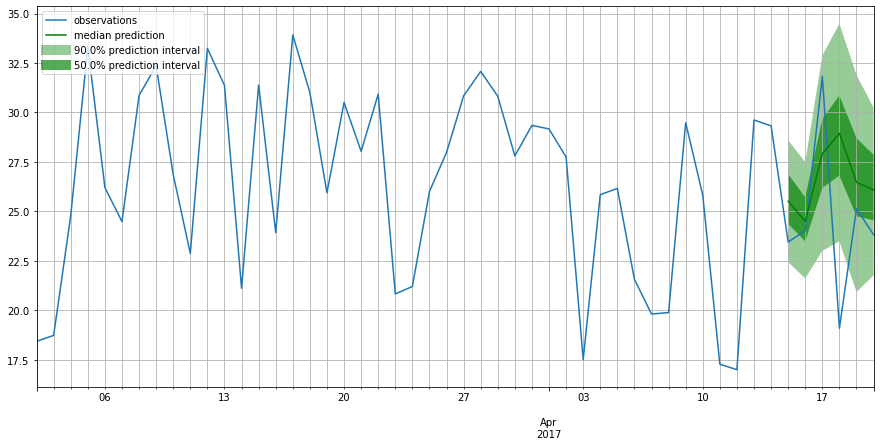

In [85]:
forecast_ind = 1
ts_entry = tss[forecast_ind]
forecast_entry = forecasts[forecast_ind]
plot_prob_forecasts(ts_entry, forecast_entry)

In [32]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])

In [80]:
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(tss))

Running evaluation: 100%|██████████| 20/20 [00:00<00:00, 456.88it/s]


In [81]:
agg_metrics

{'MSE': 46.419191805521635,
 'abs_error': 620.7741851806641,
 'abs_target_sum': 4789.912414550781,
 'abs_target_mean': 39.91593678792317,
 'seasonal_error': 6.026568010009882,
 'MASE': 0.8603722691280133,
 'MAPE': 0.13412367818305354,
 'sMAPE': 0.13092530047612866,
 'OWA': nan,
 'MSIS': 7.1764503956298515,
 'QuantileLoss[0.1]': 306.92610340118415,
 'Coverage[0.1]': 0.23333333333333334,
 'QuantileLoss[0.5]': 620.7741851806641,
 'Coverage[0.5]': 0.4750000000000001,
 'QuantileLoss[0.9]': 310.3849514007568,
 'Coverage[0.9]': 0.7833333333333333,
 'RMSE': 6.813163127763905,
 'NRMSE': 0.17068779229616557,
 'ND': 0.12960032072713443,
 'wQuantileLoss[0.1]': 0.0640776024356531,
 'wQuantileLoss[0.5]': 0.12960032072713443,
 'wQuantileLoss[0.9]': 0.06479971334295599,
 'mean_wQuantileLoss': 0.08615921216858118,
 'MAE_Coverage': 0.09166666666666663}

In [72]:
import lightgbm as lgbm
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [67]:
tree_model = lgbm.LGBMRegressor().fit(
    tree_train_df.drop([target_col, date_col], axis=1), tree_train_df.loc[:, target_col]
)

In [68]:
test_pred = tree_model.predict(tree_test_df.drop([target_col, date_col], axis=1))

In [75]:
mean_absolute_error(test_pred, tree_test_df.loc[:, target_col]), mean_squared_error(
    test_pred, tree_test_df.loc[:, target_col]
)

(5.297104477408029, 47.30780950185852)

In [ ]:
SampleForecast()

In [78]:
type(forecast_entry)

gluonts.model.forecast.SampleForecast

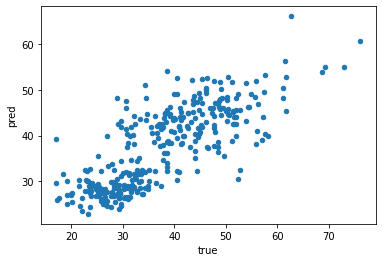

In [90]:
pd.DataFrame(
    {"pred": test_pred, "true": tree_test_df.loc[:, target_col].values}
).plot.scatter(x="true", y="pred")

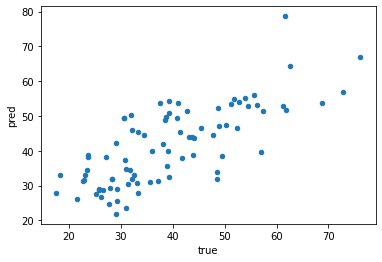

In [121]:
pd.concat(
    [
        pd.DataFrame(
            {
                "pred": fc.samples.mean(axis=0),
                "true": truevals.loc[break_date:, :]
                .iloc[:prediction_length, :]
                .values[:, 0],
            }
        )
        for fc, truevals in zip(forecasts, tss)
        if truevals.index[-prediction_length] > pd.Timestamp(break_date)
    ]
).plot.scatter(x="true", y="pred")